## Sim Demo

### Imports

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from env.imports import *

In [44]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *

#### Check job specs

In [45]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 4.0%
RAM Usage: 5.9%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


## Wandb API Query <a id="sims"></a>

Basic test

In [46]:
import wandb
from datetime import datetime, timedelta

api = wandb.Api()

project_path = "alexander-ratzan-new-york-university/gx2conn"

models = ['cge', 'gaussian_kernel', 'exponential_decay', 'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank', 'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']
model_groups = {'feature based': ['cge', 'gaussian_kernel', 'exponential_decay'], 
'bilinear': ['bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank'], 
'non linear': ['dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']}

cv_types = ['random', 'spatial']
feature_types = ['euclidean', 'transcriptome', 'transcriptome_PCA']
null_model = ['none', 'spin']
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]
folds = [0, 1, 2, 3]


model = 'cge'
cv_type = 'random'
null_model = 'none'
feature_type = 'transcriptome_PCA'

time_filter = datetime.now() - timedelta(days=30)

filters = {
    "tags": {
        "$all": [
            "final_eval",
            f"model_{model}",
            f"cv_type_{cv_type}",
            f"null_model_{null_model}",
            f"feature_type_{feature_type}"
        ]
    },
    "created_at": {"$gte": time_filter.isoformat()},
    "state": "finished"
}

runs = api.runs(project_path, filters=filters, order="-created_at")
run_data = []
for run in runs:
    # Extract all metrics from final_train_metrics and final_test_metrics
    metrics = {}
    
    if 'final_train_metrics' in run.summary:
        for k, v in run.summary['final_train_metrics'].items():
            metrics[f'train_{k}'] = v
            
    if 'final_test_metrics' in run.summary:
        for k, v in run.summary['final_test_metrics'].items():
            metrics[f'test_{k}'] = v
    
    run_info = {
        'run_name': run.name,
        **metrics
    }
    run_data.append(run_info)

df = pd.DataFrame(run_data)
print(f"\nDataFrame created with {len(df)} runs")
print(f"Columns: {list(df.columns)}")


DataFrame created with 0 runs
Columns: []


Search and plot Random

In [38]:
from collections import defaultdict

# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

cv_type = 'random'
null_model = 'none'
within_last = 90
before_last = 0

# Store summary DataFrames
summary_dict_random = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_random, within_last=within_last, before_last=before_last)

cv_type = 'random'
null_model = 'spin'

# Store summary DataFrames
summary_dict_random_spin = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_random_spin, within_last=within_last, before_last=before_last)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=random, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=random, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=random, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with transcript

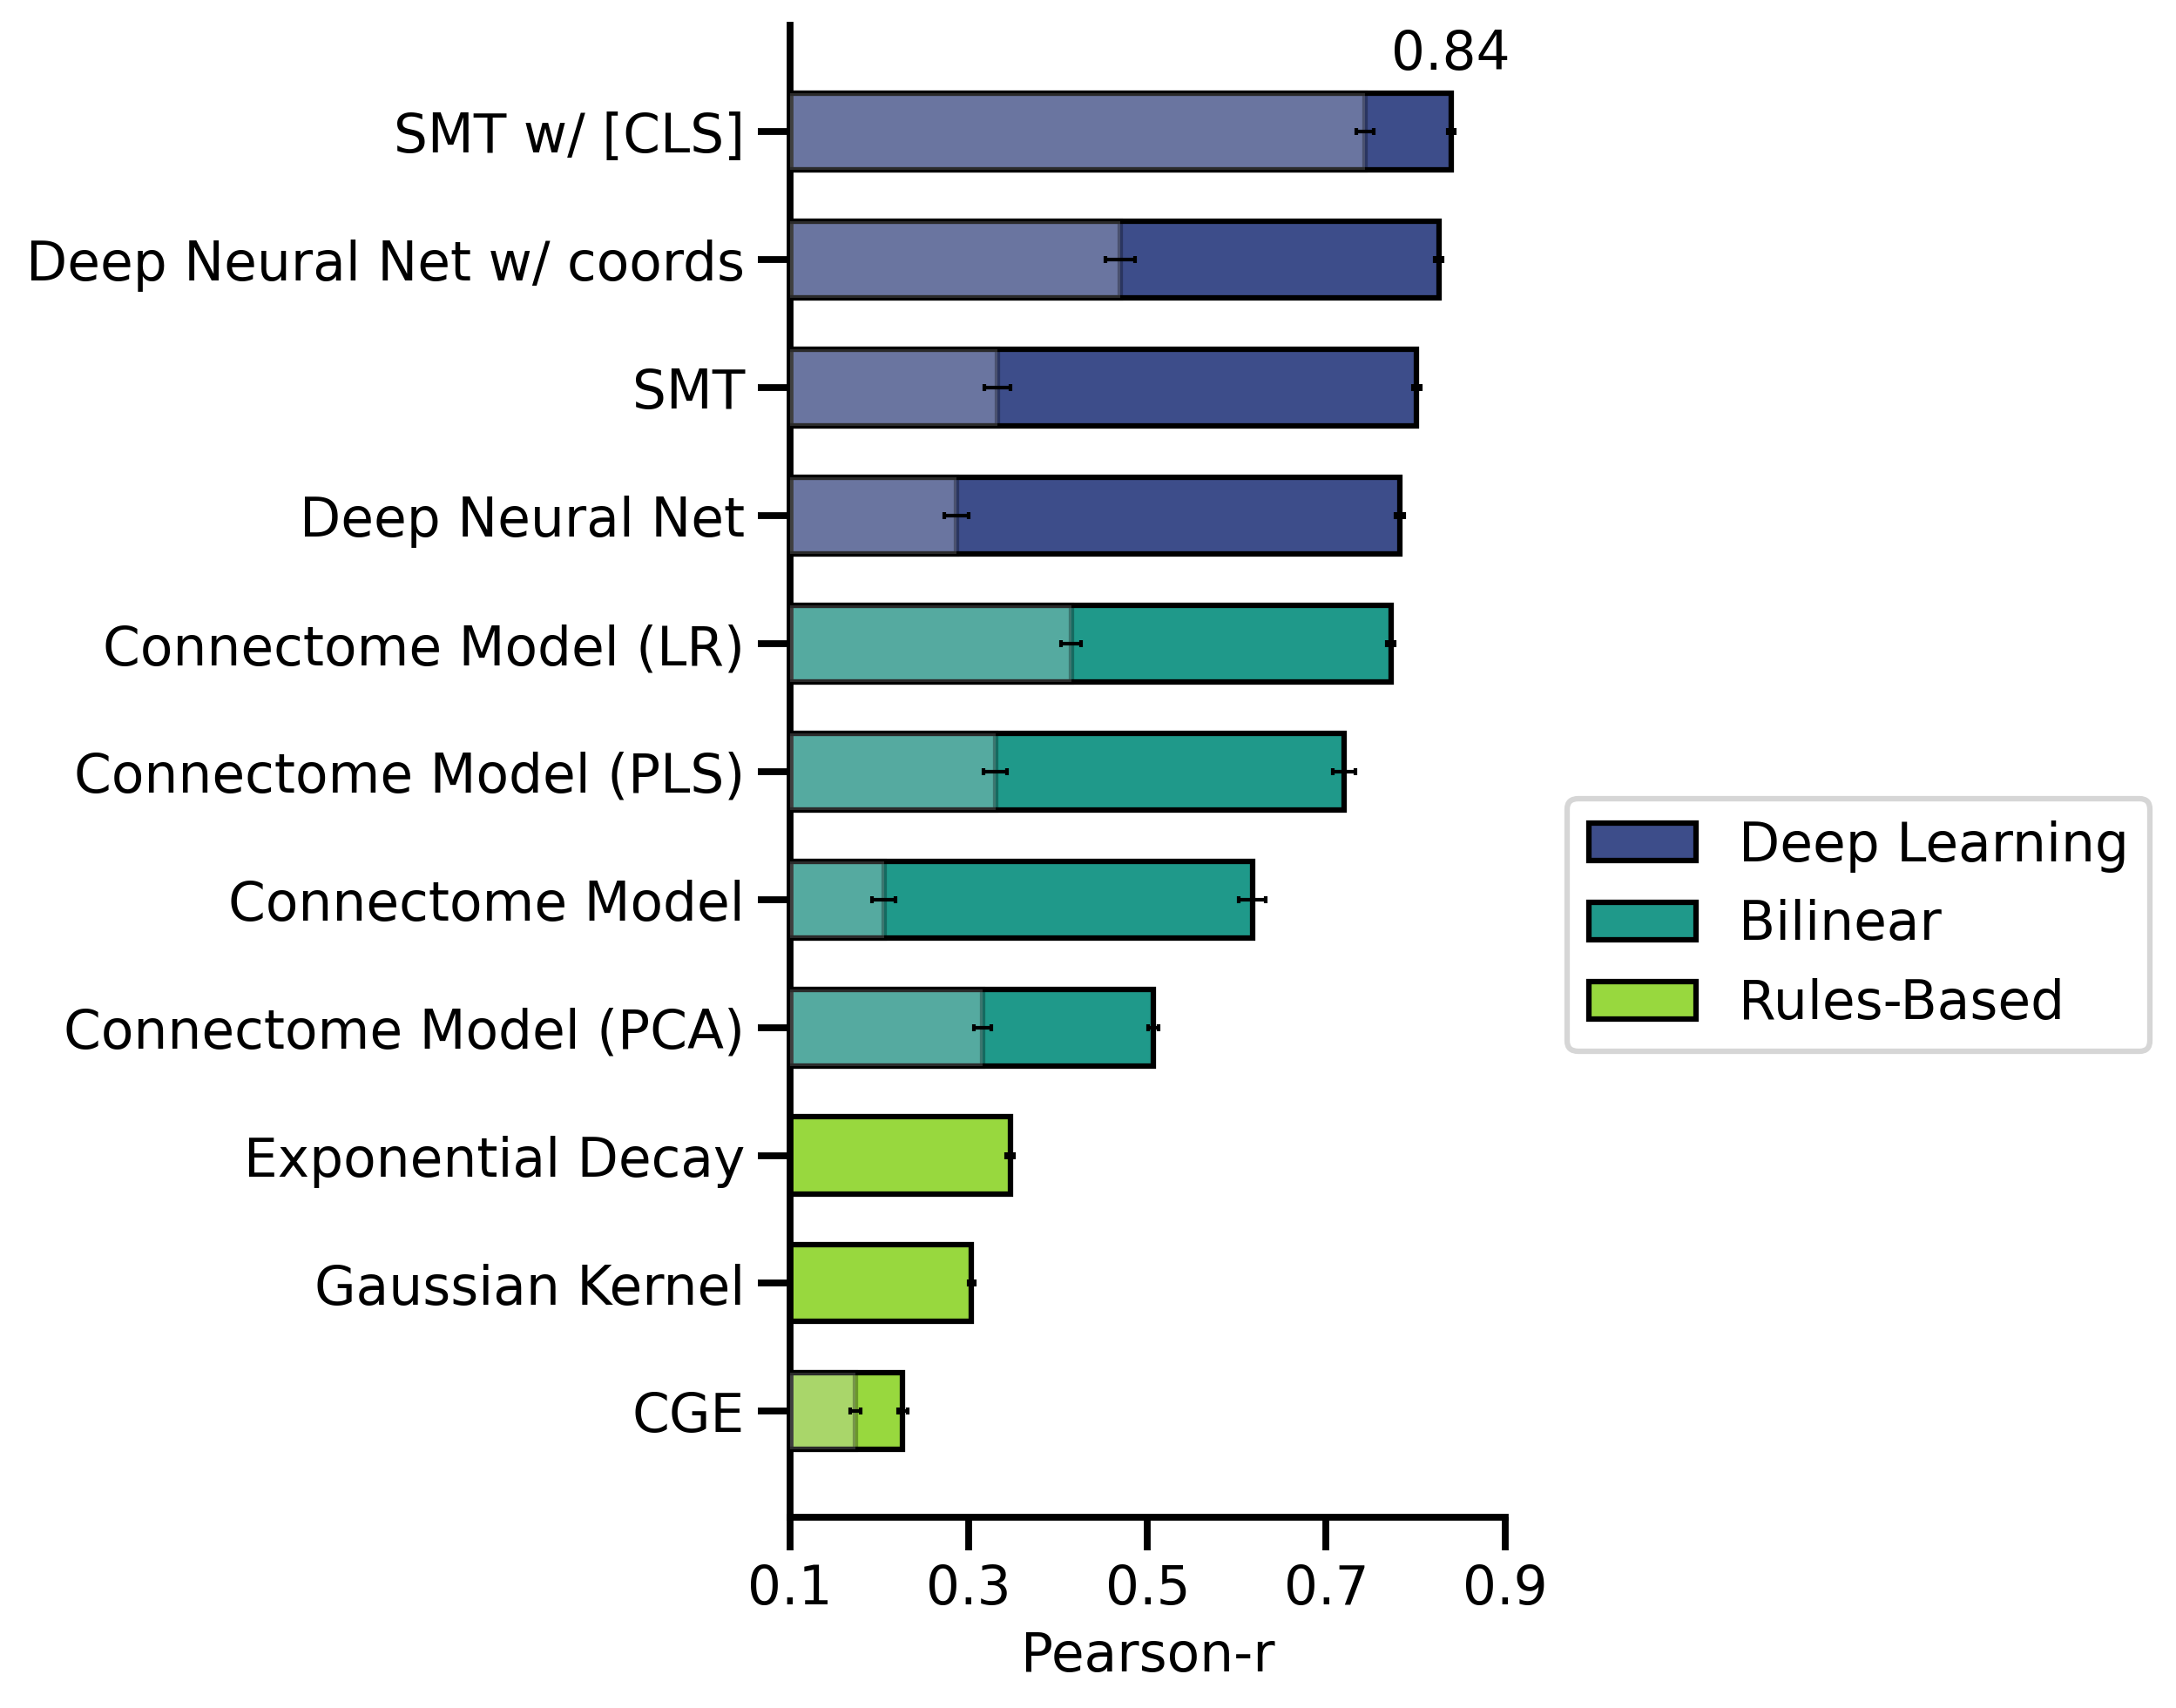

In [47]:
plot_true_vs_null_model_barchart_w_legend(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

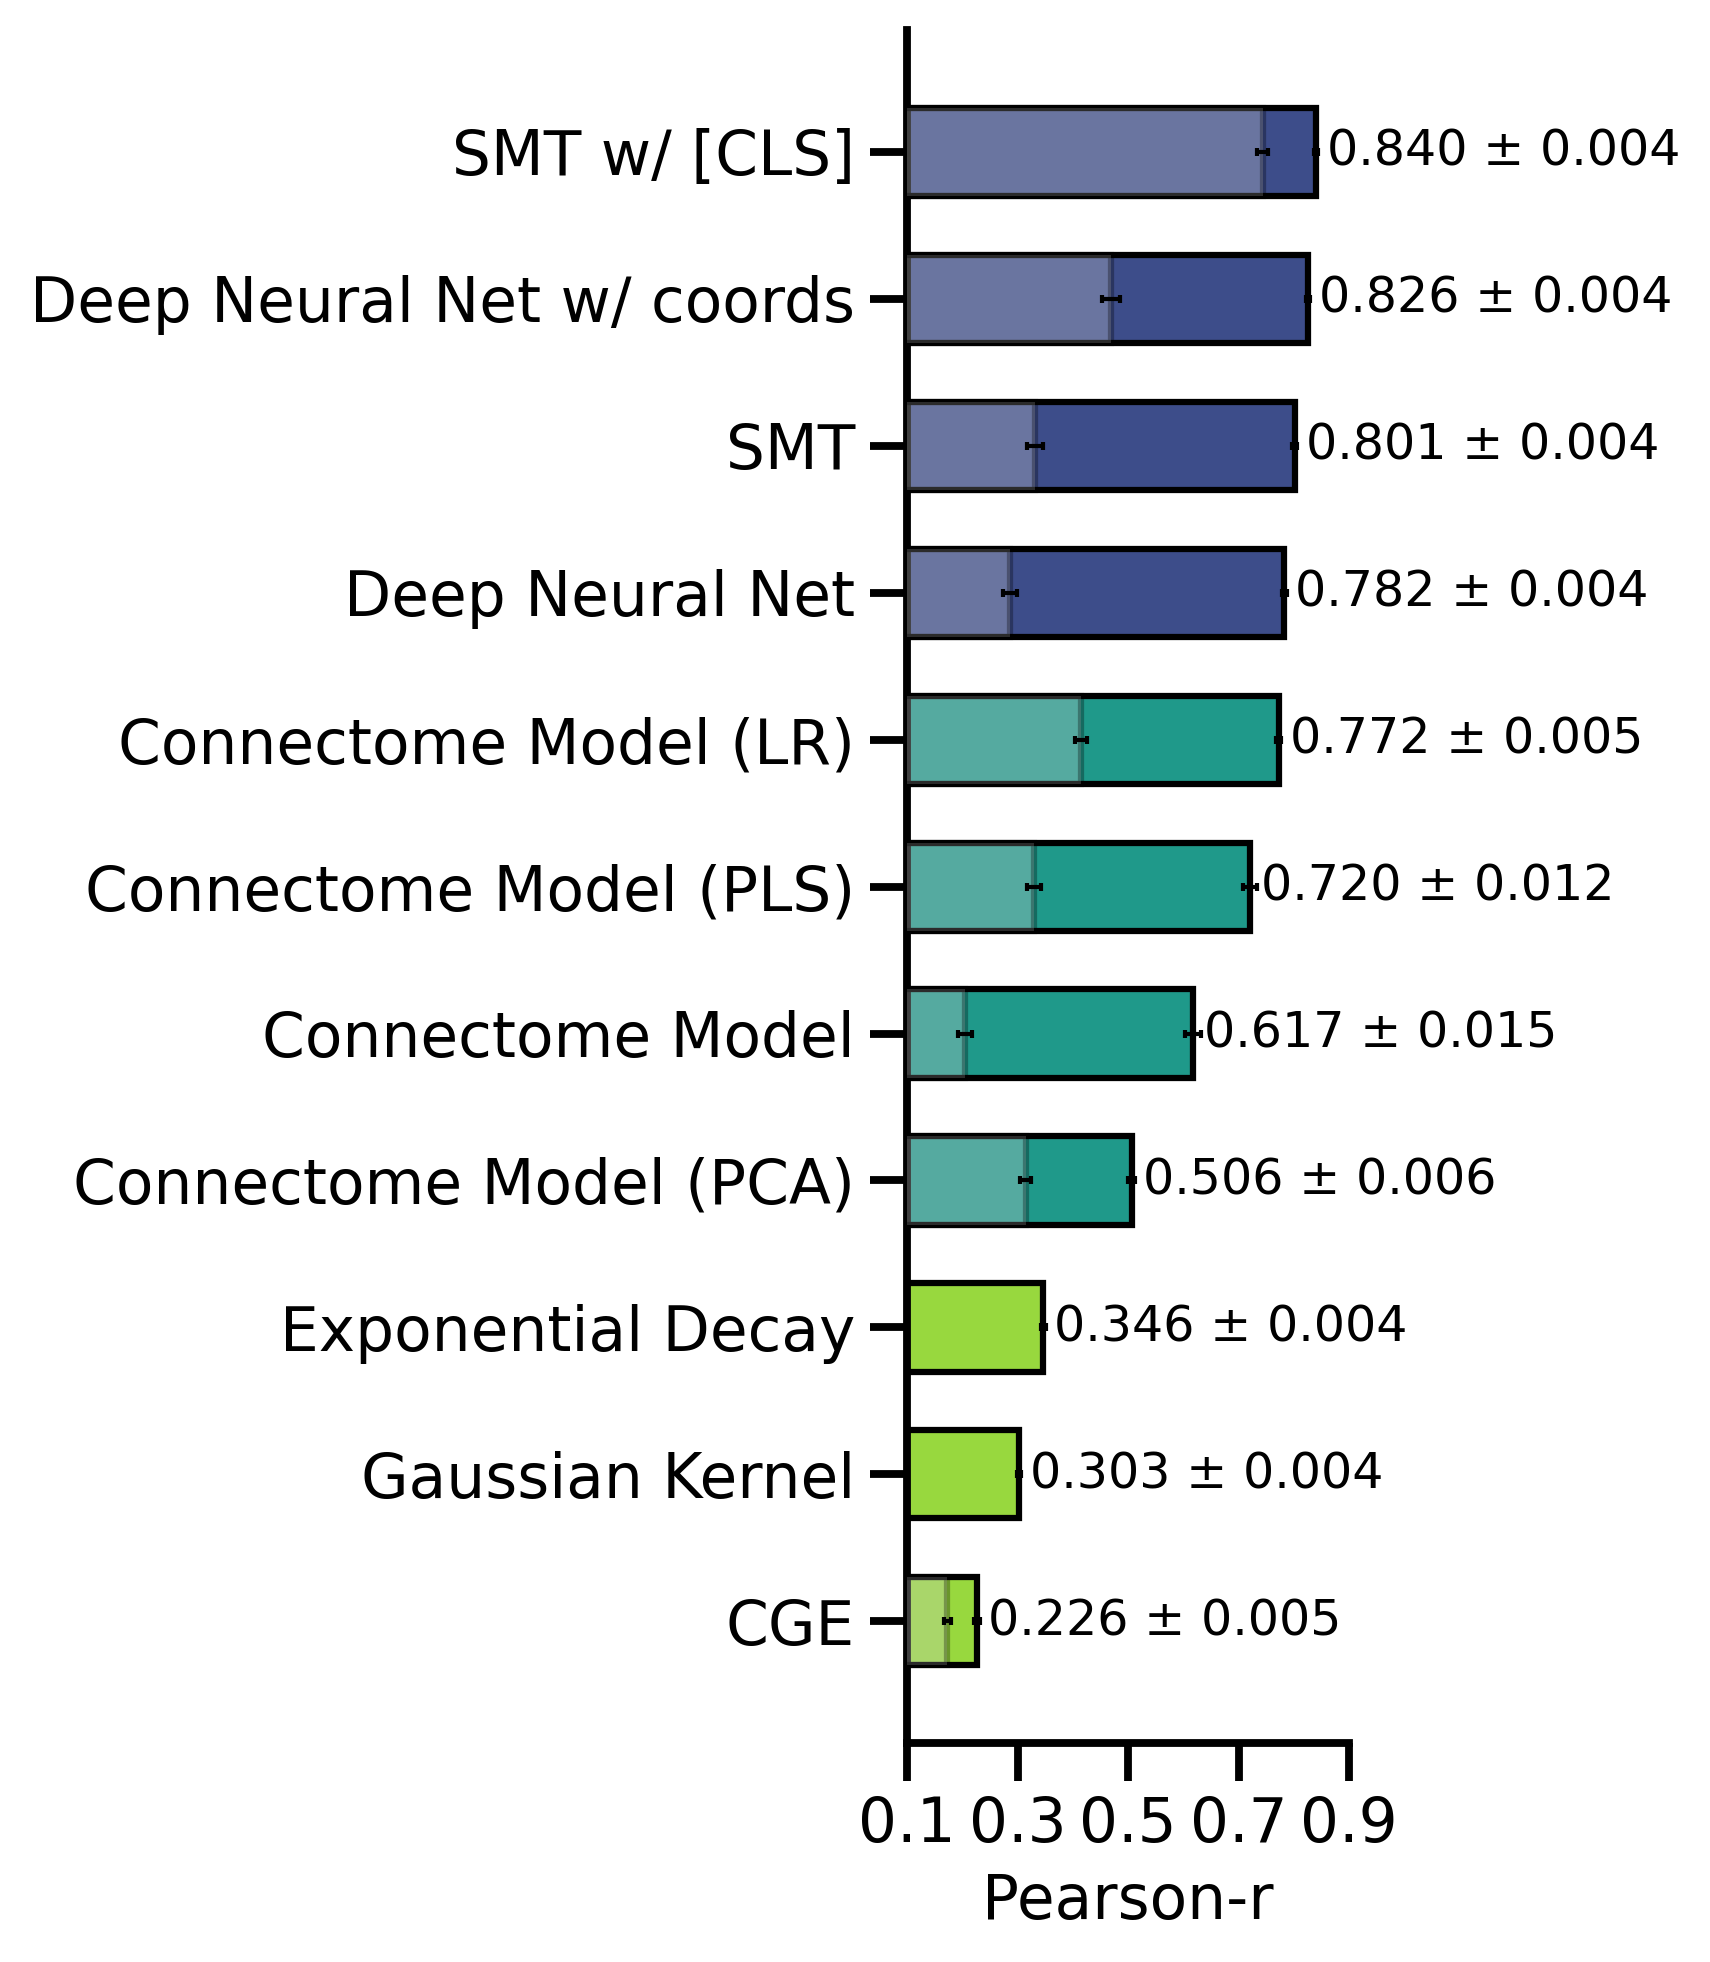

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [48]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

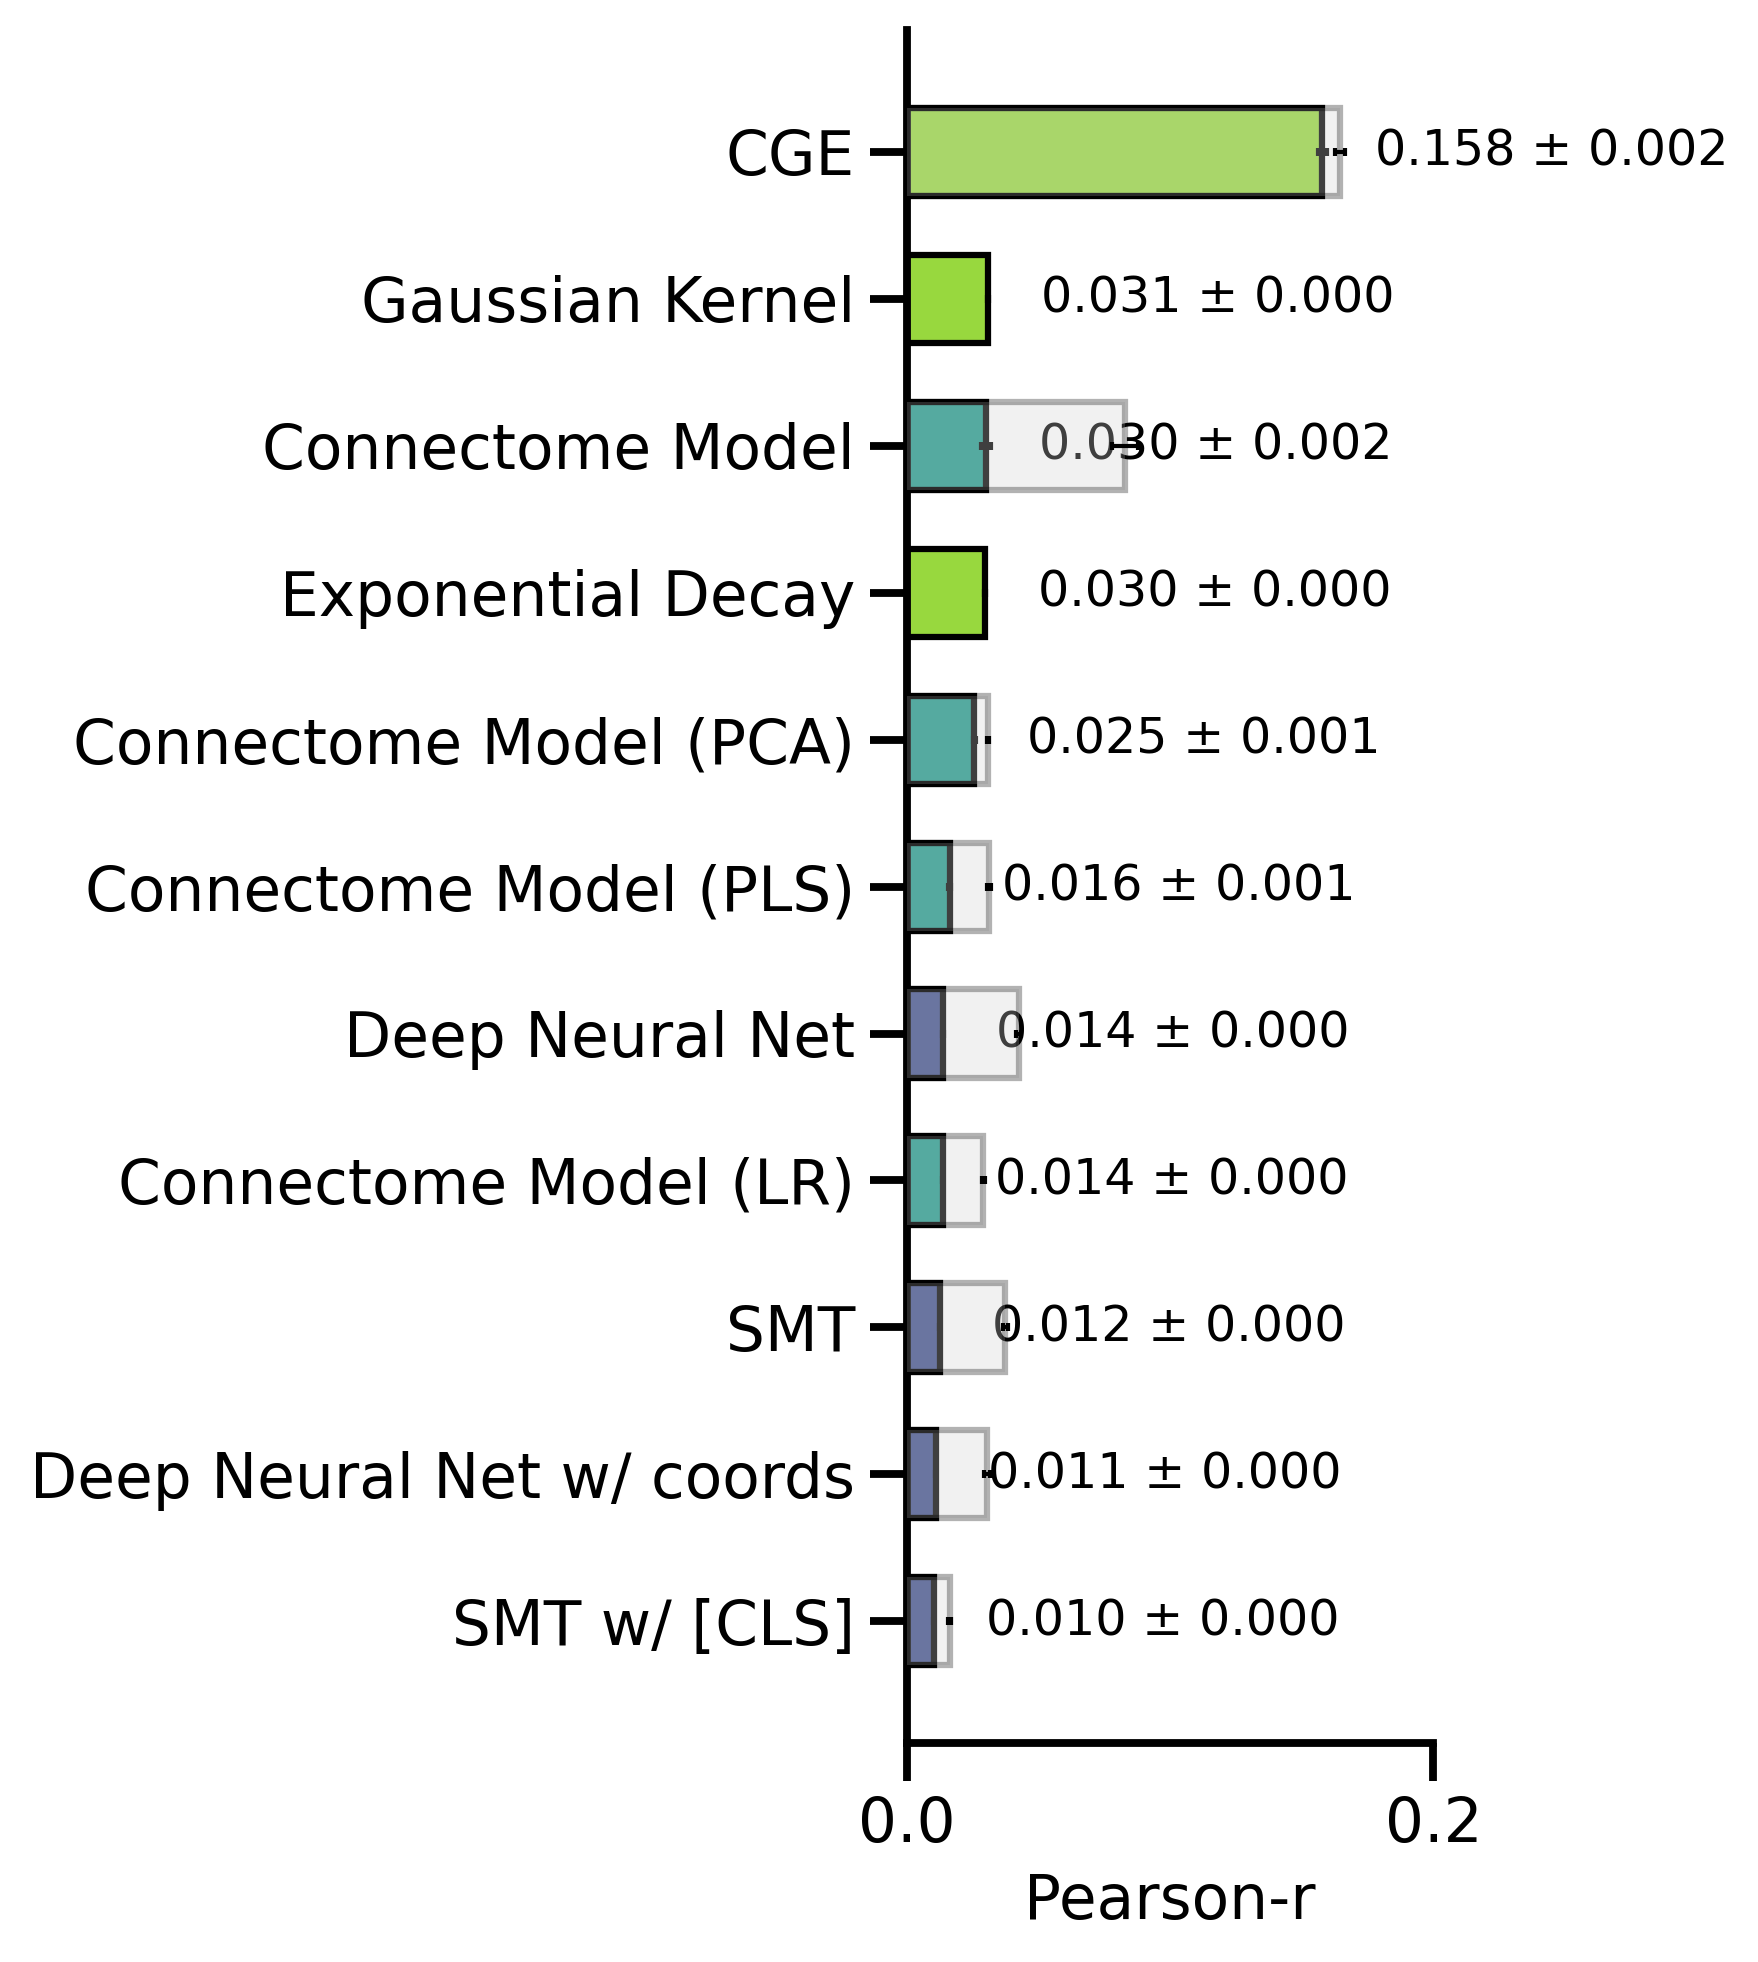

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [49]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_mse",
    xlim=(0.0, 0.05),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

Search and plot spatial

In [50]:
# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

model_groups = {
    'rules based': ['cge', 'gaussian_kernel', 'exponential_decay'],
    'bilinear': ['bilinear_CM', 'bilinear_CM_PCA', 'pls_bilineardecoder', 'bilinear_lowrank'],
    'deep learning': ['dynamic_mlp', 'dynamic_mlp_coords', 'shared_transformer', 'shared_transformer_cls']
}


cv_type = 'spatial'
null_model = 'none'

within_last = 90
before_last = 0

# Store summary DataFrames
summary_dict_spatial = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_spatial, within_last=within_last, before_last=before_last)


cv_type = 'spatial'
null_model = 'spin'

# Store summary DataFrames
summary_dict_spatial_spin = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_spatial_spin, within_last=within_last, before_last=before_last)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=spatial, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=spatial, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with tran

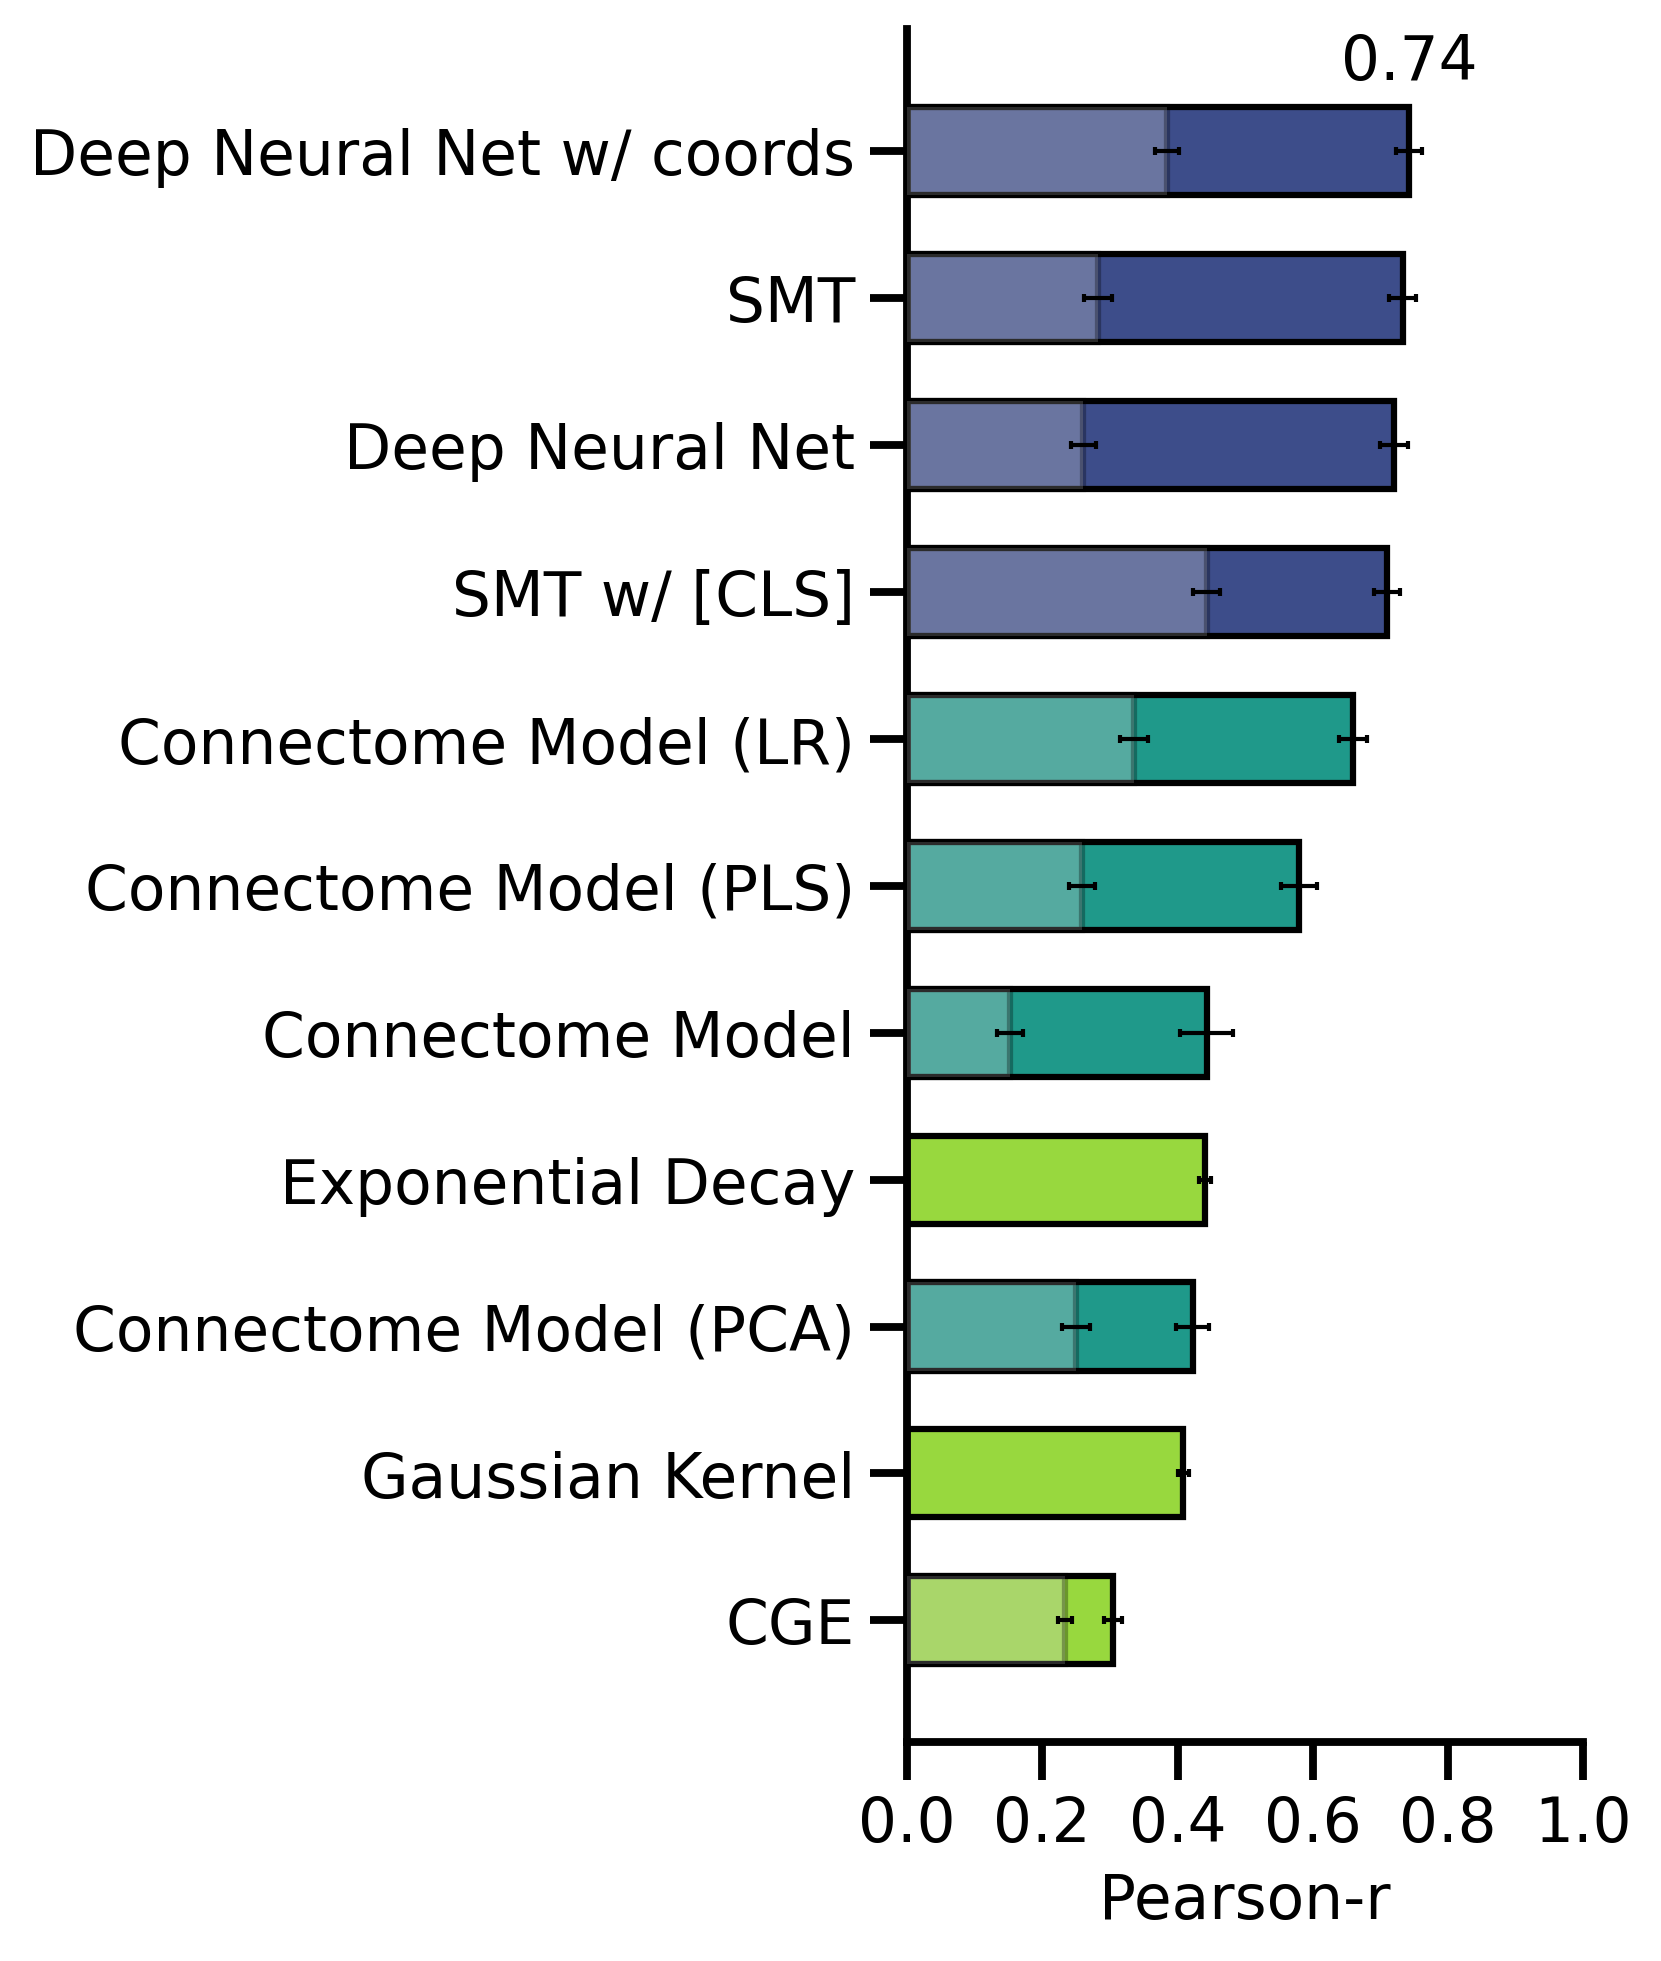

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [51]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.0, 1),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=False
)

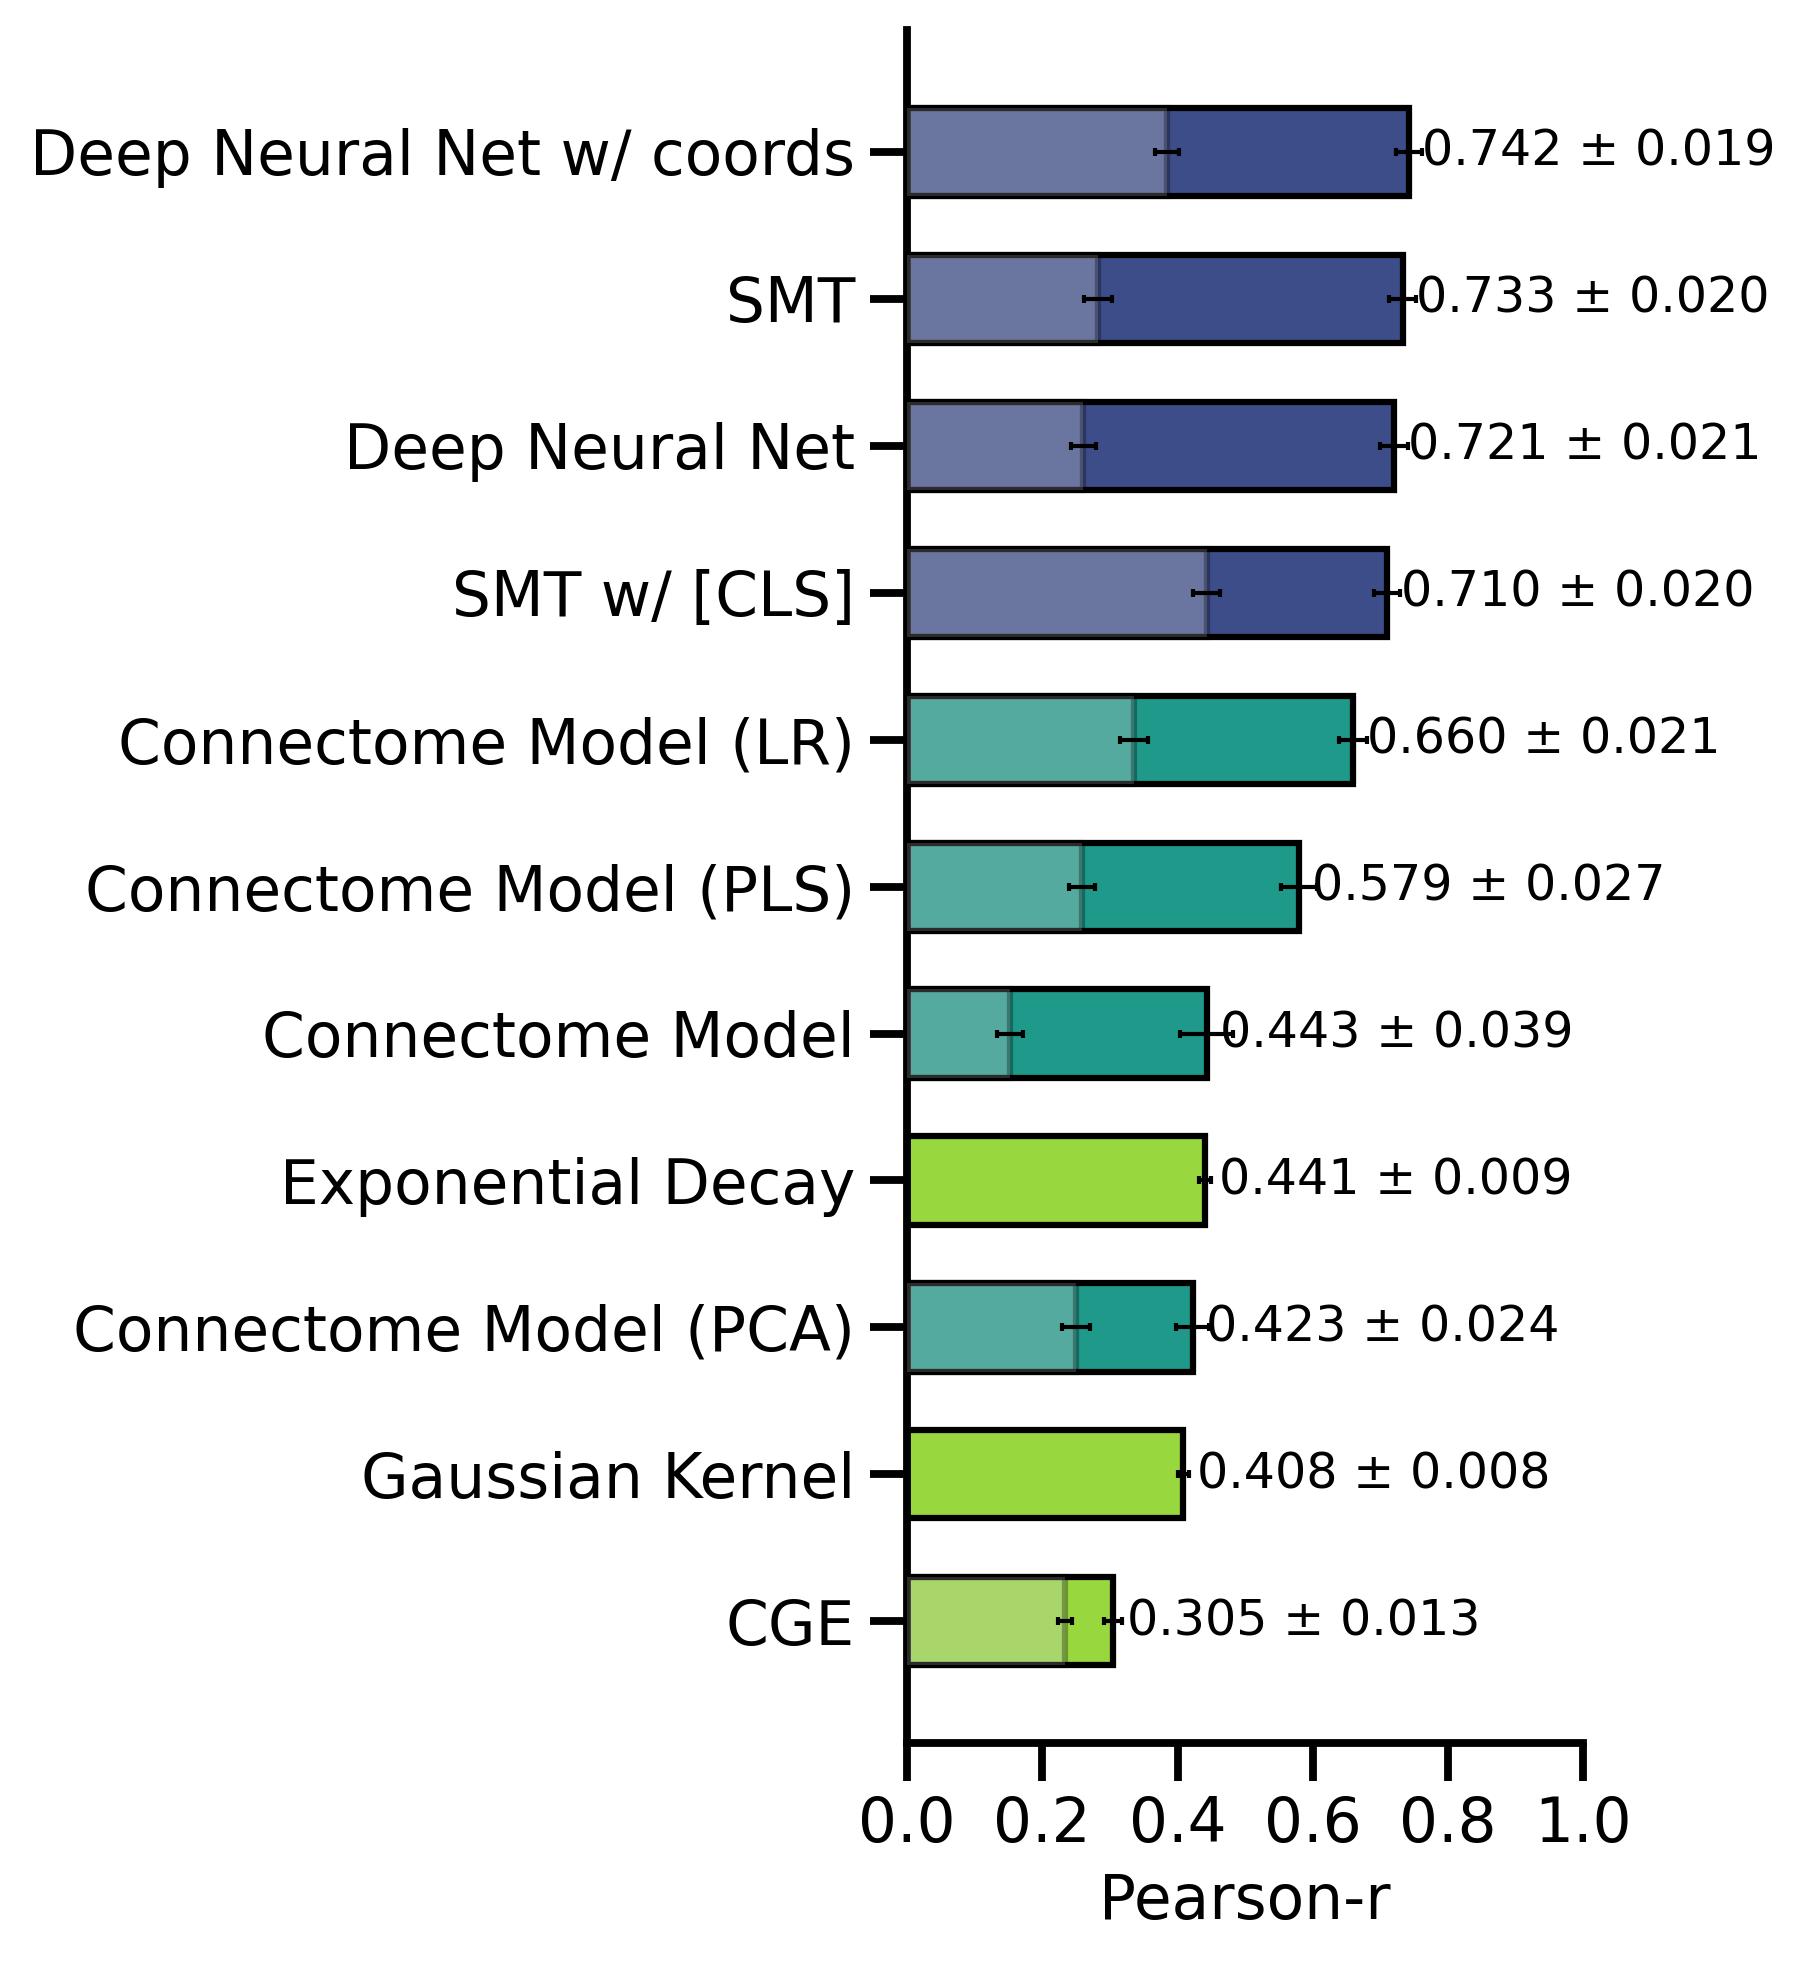

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [52]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.0, 1),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

Build table with all relevant metrics

In [53]:
summary_dict_spatial

{'cge':         train_geodesic_distance  train_inter_hemi_r  \
 mean                  22.708445            0.211864   
 std                    1.461010            0.030277   
 stderr                 0.231006            0.004787   
 
         train_inter_network_Cerebellum_r  train_inter_network_Cont_r  \
 mean                            0.199925                    0.214440   
 std                             0.046381                    0.042539   
 stderr                          0.007730                    0.006726   
 
         train_inter_network_Default_r  train_inter_network_DorsAttn_r  \
 mean                         0.212240                        0.203489   
 std                          0.035793                        0.045540   
 stderr                       0.005659                        0.007201   
 
         train_inter_network_Limbic_r  train_inter_network_SalVentAttn_r  \
 mean                        0.210147                           0.208913   
 std                   

In [57]:
def create_test_metric_dataframes(summary_dict):
    # Initialize empty lists for global and subnetwork metrics
    global_metrics = []
    subnetwork_metrics = []
    
    # Define global metric columns
    global_cols = ['pearson_r', 'r2', 'short_r', 'mid_r', 'long_r',
                  'strong_pos_r', 'strong_neg_r', 'weak_r',
                  'left_hemi_r', 'right_hemi_r', 'inter_hemi_r',
                  'mse', 'geodesic_distance']
                  
    # Define subnetworks
    networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 
                'Cont', 'Default', 'Subcortical', 'Cerebellum']
    
    # Process each model
    model_order = ['shared_transformer_cls', 'dynamic_mlp_coords', 'shared_transformer', 'dynamic_mlp']
    remaining_models = [m for m in reversed(summary_dict.keys()) if m not in model_order]
    ordered_models = model_order + remaining_models
    
    for model in ordered_models:
        if model not in summary_dict:
            continue
            
        df = summary_dict[model]
        
        # Global metrics
        global_row = {}
        for col in global_cols:
            mean = df.loc['mean', f'test_{col}']
            std = df.loc['std', f'test_{col}']
            global_row[col] = f"{mean:.3f} ± {std:.3f}"
        global_metrics.append({'Model': model, **global_row})
        
        # Subnetwork metrics  
        subnetwork_row = {'Model': model}
        for network in networks:
            # Intra-network correlation
            intra_mean = df.loc['mean', f'test_intra_network_{network}_r']
            intra_std = df.loc['std', f'test_intra_network_{network}_r']
            subnetwork_row[f'{network} Intra'] = f"{intra_mean:.3f} ± {intra_std:.3f}"
            
            # Inter-network correlation
            inter_mean = df.loc['mean', f'test_inter_network_{network}_r'] 
            inter_std = df.loc['std', f'test_inter_network_{network}_r']
            subnetwork_row[f'{network} Inter'] = f"{inter_mean:.3f} ± {inter_std:.3f}"
            
        subnetwork_metrics.append(subnetwork_row)
    
    # Create dataframes
    global_df = pd.DataFrame(global_metrics).set_index('Model')
    subnetwork_df = pd.DataFrame(subnetwork_metrics).set_index('Model')
    
    return global_df, subnetwork_df

In [58]:
# Create the dataframes for random
global_metrics_df_random, subnetwork_metrics_df_random = create_test_metric_dataframes(summary_dict_random)

print("\nRandom Test Metrics:")
print("\nGlobal Test Metrics:")
display(global_metrics_df_random)
print("\nSubnetwork Test Metrics:") 
display(subnetwork_metrics_df_random)


Random Test Metrics:

Global Test Metrics:


,pearson_r,r2,short_r,mid_r,long_r,strong_pos_r,strong_neg_r,weak_r,left_hemi_r,right_hemi_r,inter_hemi_r,mse,geodesic_distance
Model,,,,,,,,,,,,,
shared_transformer_cls,0.840 ± 0.025,0.698 ± 0.044,0.857 ± 0.022,0.814 ± 0.029,0.783 ± 0.054,0.539 ± 0.068,0.237 ± 0.113,0.745 ± 0.036,0.821 ± 0.040,0.860 ± 0.026,0.838 ± 0.028,0.010 ± 0.002,9.930 ± 0.971
dynamic_mlp_coords,0.826 ± 0.027,0.674 ± 0.048,0.847 ± 0.025,0.798 ± 0.031,0.753 ± 0.064,0.530 ± 0.071,0.154 ± 0.128,0.729 ± 0.034,0.817 ± 0.035,0.847 ± 0.033,0.820 ± 0.031,0.011 ± 0.001,9.772 ± 0.797
shared_transformer,0.801 ± 0.027,0.627 ± 0.050,0.832 ± 0.025,0.771 ± 0.030,0.704 ± 0.067,0.475 ± 0.072,0.129 ± 0.138,0.697 ± 0.034,0.790 ± 0.038,0.835 ± 0.036,0.792 ± 0.030,0.012 ± 0.001,10.215 ± 1.006
dynamic_mlp,0.782 ± 0.028,0.591 ± 0.051,0.817 ± 0.026,0.750 ± 0.032,0.670 ± 0.060,0.479 ± 0.073,0.101 ± 0.128,0.672 ± 0.035,0.780 ± 0.041,0.815 ± 0.039,0.768 ± 0.034,0.014 ± 0.001,10.270 ± 0.741
bilinear_lowrank,0.772 ± 0.029,0.594 ± 0.044,0.798 ± 0.025,0.741 ± 0.035,0.695 ± 0.060,0.399 ± 0.066,0.086 ± 0.121,0.682 ± 0.040,0.754 ± 0.046,0.803 ± 0.033,0.771 ± 0.031,0.014 ± 0.001,11.183 ± 1.103
pls_bilineardecoder,0.720 ± 0.079,0.517 ± 0.103,0.754 ± 0.078,0.678 ± 0.089,0.626 ± 0.109,0.370 ± 0.096,0.058 ± 0.125,0.621 ± 0.081,0.703 ± 0.089,0.749 ± 0.077,0.718 ± 0.078,0.016 ± 0.004,11.956 ± 1.929
bilinear_CM_PCA,0.506 ± 0.037,0.239 ± 0.077,0.567 ± 0.048,0.429 ± 0.039,0.347 ± 0.069,0.306 ± 0.078,0.019 ± 0.117,0.374 ± 0.034,0.490 ± 0.052,0.553 ± 0.047,0.498 ± 0.042,0.025 ± 0.003,15.302 ± 0.639
bilinear_CM,0.617 ± 0.095,0.093 ± 0.396,0.629 ± 0.118,0.592 ± 0.091,0.552 ± 0.089,0.223 ± 0.103,0.082 ± 0.119,0.528 ± 0.089,0.652 ± 0.084,0.687 ± 0.076,0.583 ± 0.113,0.030 ± 0.012,16.070 ± 1.388
exponential_decay,0.346 ± 0.028,0.117 ± 0.022,0.411 ± 0.038,0.070 ± 0.032,0.095 ± 0.069,0.338 ± 0.045,0.113 ± 0.091,0.195 ± 0.024,0.399 ± 0.048,0.428 ± 0.045,0.242 ± 0.044,0.030 ± 0.003,15.667 ± 0.711



Subnetwork Test Metrics:


,Vis Intra,Vis Inter,SomMot Intra,SomMot Inter,DorsAttn Intra,DorsAttn Inter,SalVentAttn Intra,SalVentAttn Inter,Limbic Intra,Limbic Inter,Cont Intra,Cont Inter,Default Intra,Default Inter,Subcortical Intra,Subcortical Inter,Cerebellum Intra,Cerebellum Inter
Model,,,,,,,,,,,,,,,,,,
shared_transformer_cls,0.876 ± 0.073,0.865 ± 0.034,0.875 ± 0.060,0.873 ± 0.028,0.851 ± 0.090,0.871 ± 0.030,0.847 ± 0.120,0.860 ± 0.031,0.852 ± 0.162,0.862 ± 0.037,0.826 ± 0.115,0.847 ± 0.043,0.800 ± 0.079,0.836 ± 0.036,0.785 ± 0.120,0.847 ± 0.030,0.484 ± 0.600,0.843 ± 0.042
dynamic_mlp_coords,0.878 ± 0.055,0.866 ± 0.024,0.870 ± 0.056,0.866 ± 0.028,0.841 ± 0.111,0.866 ± 0.030,0.855 ± 0.085,0.860 ± 0.031,0.848 ± 0.140,0.859 ± 0.035,0.824 ± 0.106,0.846 ± 0.040,0.824 ± 0.057,0.840 ± 0.030,0.775 ± 0.122,0.843 ± 0.028,0.563 ± 0.505,0.840 ± 0.044
shared_transformer,0.874 ± 0.048,0.846 ± 0.024,0.842 ± 0.068,0.848 ± 0.030,0.833 ± 0.117,0.850 ± 0.033,0.826 ± 0.126,0.839 ± 0.035,0.876 ± 0.099,0.842 ± 0.038,0.802 ± 0.088,0.822 ± 0.044,0.803 ± 0.064,0.820 ± 0.027,0.705 ± 0.209,0.816 ± 0.036,0.591 ± 0.526,0.812 ± 0.043
dynamic_mlp,0.863 ± 0.064,0.834 ± 0.026,0.836 ± 0.068,0.839 ± 0.033,0.809 ± 0.140,0.840 ± 0.040,0.813 ± 0.169,0.829 ± 0.041,0.826 ± 0.174,0.827 ± 0.046,0.783 ± 0.095,0.810 ± 0.041,0.781 ± 0.069,0.804 ± 0.031,0.652 ± 0.258,0.800 ± 0.038,0.678 ± 0.276,0.791 ± 0.058
bilinear_lowrank,0.838 ± 0.065,0.818 ± 0.027,0.821 ± 0.061,0.827 ± 0.031,0.803 ± 0.137,0.830 ± 0.039,0.788 ± 0.136,0.812 ± 0.045,0.803 ± 0.156,0.816 ± 0.040,0.766 ± 0.148,0.799 ± 0.049,0.773 ± 0.066,0.793 ± 0.033,0.680 ± 0.199,0.795 ± 0.034,0.543 ± 0.691,0.789 ± 0.051
pls_bilineardecoder,0.794 ± 0.085,0.770 ± 0.072,0.774 ± 0.100,0.782 ± 0.074,0.767 ± 0.153,0.789 ± 0.064,0.742 ± 0.198,0.771 ± 0.083,0.781 ± 0.218,0.779 ± 0.066,0.721 ± 0.163,0.751 ± 0.077,0.723 ± 0.083,0.740 ± 0.082,0.619 ± 0.195,0.744 ± 0.076,0.829 ± 0.367,0.735 ± 0.089
bilinear_CM_PCA,0.603 ± 0.125,0.566 ± 0.055,0.570 ± 0.129,0.573 ± 0.069,0.598 ± 0.224,0.598 ± 0.070,0.559 ± 0.174,0.586 ± 0.060,0.635 ± 0.255,0.590 ± 0.082,0.497 ± 0.239,0.538 ± 0.085,0.433 ± 0.126,0.508 ± 0.064,0.399 ± 0.225,0.510 ± 0.056,0.038 ± 0.852,0.495 ± 0.086
bilinear_CM,0.727 ± 0.115,0.682 ± 0.088,0.658 ± 0.136,0.684 ± 0.103,0.653 ± 0.201,0.690 ± 0.100,0.647 ± 0.214,0.667 ± 0.105,0.712 ± 0.231,0.679 ± 0.090,0.658 ± 0.145,0.663 ± 0.097,0.620 ± 0.151,0.639 ± 0.093,0.472 ± 0.304,0.648 ± 0.087,0.109 ± 0.726,0.646 ± 0.096
exponential_decay,0.497 ± 0.156,0.332 ± 0.092,0.332 ± 0.144,0.356 ± 0.057,0.089 ± 0.226,0.313 ± 0.073,0.299 ± 0.261,0.340 ± 0.061,0.200 ± 0.390,0.349 ± 0.080,0.217 ± 0.224,0.322 ± 0.074,0.298 ± 0.160,0.281 ± 0.043,0.235 ± 0.325,0.294 ± 0.064,0.195 ± 0.807,0.276 ± 0.068


In [59]:
# Create the dataframes for spatial
global_metrics_df_spatial, subnetwork_metrics_df_spatial = create_test_metric_dataframes(summary_dict_spatial)

print("Spatial Test Metrics:")
print("\nGlobal Test Metrics:")
display(global_metrics_df_spatial)
print("\nSubnetwork Test Metrics:") 
display(subnetwork_metrics_df_spatial)


Spatial Test Metrics:

Global Test Metrics:


,pearson_r,r2,short_r,mid_r,long_r,strong_pos_r,strong_neg_r,weak_r,left_hemi_r,right_hemi_r,inter_hemi_r,mse,geodesic_distance
Model,,,,,,,,,,,,,
shared_transformer_cls,0.710 ± 0.124,0.453 ± 0.278,0.710 ± 0.138,0.625 ± 0.138,0.590 ± 0.199,0.408 ± 0.123,0.083 ± 0.145,0.556 ± 0.137,0.681 ± 0.157,0.708 ± 0.196,0.624 ± 0.200,0.023 ± 0.010,11.259 ± 1.818
dynamic_mlp_coords,0.742 ± 0.121,0.504 ± 0.261,0.744 ± 0.132,0.668 ± 0.134,0.585 ± 0.215,0.468 ± 0.107,0.086 ± 0.184,0.588 ± 0.142,0.715 ± 0.137,0.745 ± 0.143,0.666 ± 0.149,0.021 ± 0.010,10.353 ± 1.949
shared_transformer,0.733 ± 0.129,0.471 ± 0.329,0.736 ± 0.142,0.662 ± 0.137,0.519 ± 0.256,0.402 ± 0.112,0.096 ± 0.201,0.592 ± 0.141,0.706 ± 0.149,0.730 ± 0.176,0.654 ± 0.158,0.022 ± 0.011,11.014 ± 2.073
dynamic_mlp,0.721 ± 0.130,0.448 ± 0.316,0.727 ± 0.140,0.643 ± 0.136,0.499 ± 0.269,0.431 ± 0.119,0.081 ± 0.189,0.569 ± 0.147,0.699 ± 0.147,0.727 ± 0.140,0.627 ± 0.160,0.023 ± 0.012,10.687 ± 1.764
bilinear_lowrank,0.660 ± 0.131,0.409 ± 0.223,0.670 ± 0.147,0.566 ± 0.152,0.400 ± 0.283,0.346 ± 0.100,0.028 ± 0.172,0.524 ± 0.144,0.630 ± 0.149,0.647 ± 0.174,0.573 ± 0.163,0.025 ± 0.009,12.909 ± 2.181
pls_bilineardecoder,0.579 ± 0.168,0.297 ± 0.263,0.595 ± 0.176,0.458 ± 0.207,0.381 ± 0.250,0.324 ± 0.100,0.003 ± 0.162,0.441 ± 0.176,0.565 ± 0.208,0.561 ± 0.225,0.521 ± 0.189,0.029 ± 0.010,14.466 ± 4.083
bilinear_CM_PCA,0.423 ± 0.154,-1.281 ± 3.793,0.421 ± 0.167,0.294 ± 0.136,0.198 ± 0.236,0.217 ± 0.119,-0.020 ± 0.113,0.284 ± 0.113,0.421 ± 0.166,0.439 ± 0.197,0.386 ± 0.181,0.080 ± 0.110,16.299 ± 2.129
bilinear_CM,0.443 ± 0.246,-0.945 ± 2.710,0.432 ± 0.266,0.428 ± 0.189,0.247 ± 0.202,0.145 ± 0.193,0.011 ± 0.154,0.361 ± 0.204,0.381 ± 0.267,0.407 ± 0.268,0.272 ± 0.237,0.076 ± 0.077,16.763 ± 2.300
exponential_decay,0.441 ± 0.058,0.153 ± 0.087,0.445 ± 0.059,0.080 ± 0.080,-0.006 ± 0.125,0.356 ± 0.090,0.074 ± 0.135,0.236 ± 0.038,0.489 ± 0.098,0.497 ± 0.125,0.366 ± 0.131,0.036 ± 0.009,14.015 ± 1.310



Subnetwork Test Metrics:


,Vis Intra,Vis Inter,SomMot Intra,SomMot Inter,DorsAttn Intra,DorsAttn Inter,SalVentAttn Intra,SalVentAttn Inter,Limbic Intra,Limbic Inter,Cont Intra,Cont Inter,Default Intra,Default Inter,Subcortical Intra,Subcortical Inter,Cerebellum Intra,Cerebellum Inter
Model,,,,,,,,,,,,,,,,,,
shared_transformer_cls,0.712 ± 0.148,0.713 ± 0.111,0.751 ± 0.108,0.718 ± 0.106,0.660 ± 0.335,0.697 ± 0.133,0.686 ± 0.205,0.689 ± 0.148,0.723 ± 0.207,0.677 ± 0.153,0.673 ± 0.174,0.670 ± 0.161,0.675 ± 0.136,0.689 ± 0.129,0.640 ± 0.281,0.685 ± 0.139,0.652 ± 0.226,0.700 ± 0.130
dynamic_mlp_coords,0.760 ± 0.136,0.762 ± 0.113,0.773 ± 0.117,0.757 ± 0.112,0.757 ± 0.173,0.729 ± 0.153,0.716 ± 0.183,0.722 ± 0.159,0.732 ± 0.272,0.729 ± 0.154,0.666 ± 0.195,0.703 ± 0.151,0.722 ± 0.151,0.726 ± 0.143,0.707 ± 0.198,0.730 ± 0.149,0.541 ± 0.397,0.751 ± 0.112
shared_transformer,0.731 ± 0.175,0.760 ± 0.097,0.784 ± 0.108,0.750 ± 0.108,0.751 ± 0.198,0.730 ± 0.144,0.737 ± 0.171,0.718 ± 0.154,0.707 ± 0.307,0.715 ± 0.160,0.680 ± 0.194,0.703 ± 0.147,0.710 ± 0.143,0.719 ± 0.138,0.675 ± 0.305,0.714 ± 0.154,0.552 ± 0.387,0.744 ± 0.109
dynamic_mlp,0.760 ± 0.135,0.750 ± 0.116,0.756 ± 0.118,0.741 ± 0.116,0.727 ± 0.312,0.718 ± 0.149,0.706 ± 0.192,0.706 ± 0.163,0.704 ± 0.316,0.713 ± 0.158,0.652 ± 0.206,0.690 ± 0.150,0.703 ± 0.152,0.706 ± 0.149,0.677 ± 0.299,0.709 ± 0.155,0.505 ± 0.466,0.737 ± 0.099
bilinear_lowrank,0.645 ± 0.181,0.675 ± 0.121,0.651 ± 0.244,0.678 ± 0.116,0.656 ± 0.223,0.657 ± 0.147,0.633 ± 0.207,0.643 ± 0.175,0.660 ± 0.303,0.639 ± 0.168,0.601 ± 0.227,0.631 ± 0.156,0.648 ± 0.149,0.645 ± 0.150,0.633 ± 0.273,0.660 ± 0.162,0.482 ± 0.420,0.646 ± 0.147
pls_bilineardecoder,0.572 ± 0.210,0.590 ± 0.174,0.570 ± 0.289,0.588 ± 0.189,0.611 ± 0.185,0.566 ± 0.205,0.514 ± 0.349,0.558 ± 0.219,0.556 ± 0.391,0.561 ± 0.201,0.538 ± 0.271,0.548 ± 0.212,0.538 ± 0.214,0.552 ± 0.206,0.566 ± 0.270,0.557 ± 0.205,0.473 ± 0.377,0.552 ± 0.214
bilinear_CM_PCA,0.416 ± 0.270,0.443 ± 0.155,0.453 ± 0.175,0.449 ± 0.152,0.413 ± 0.320,0.431 ± 0.169,0.411 ± 0.283,0.429 ± 0.159,0.476 ± 0.296,0.421 ± 0.178,0.469 ± 0.185,0.429 ± 0.149,0.398 ± 0.169,0.417 ± 0.160,0.386 ± 0.309,0.407 ± 0.182,0.364 ± 0.276,0.439 ± 0.179
bilinear_CM,0.414 ± 0.348,0.464 ± 0.291,0.540 ± 0.277,0.476 ± 0.252,0.495 ± 0.301,0.471 ± 0.266,0.446 ± 0.339,0.436 ± 0.285,0.502 ± 0.390,0.456 ± 0.270,0.390 ± 0.337,0.407 ± 0.301,0.435 ± 0.295,0.427 ± 0.288,0.482 ± 0.309,0.445 ± 0.305,0.167 ± 0.556,0.407 ± 0.292
exponential_decay,0.401 ± 0.292,0.422 ± 0.066,0.425 ± 0.178,0.416 ± 0.075,0.373 ± 0.317,0.404 ± 0.090,0.448 ± 0.206,0.419 ± 0.068,0.397 ± 0.365,0.399 ± 0.103,0.412 ± 0.176,0.400 ± 0.091,0.448 ± 0.129,0.418 ± 0.081,0.412 ± 0.194,0.388 ± 0.095,0.270 ± 0.304,0.386 ± 0.129


Quick top 5 analysis

In [ ]:
# Fetch data for top 5 models
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT w/ [CLS]: {summary_df_smt_cls.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt_cls.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp_coords, history_df_mlp_coords = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'none', feature_type='transcriptome+euclidean', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net w/ coords: {summary_df_mlp_coords.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp_coords.loc['std', 'test_pearson_r']:.3f}")

summary_df_smt, history_df_smt = fetch_and_summarize_wandb_runs('shared_transformer', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT: {summary_df_smt.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp, history_df_mlp = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net: {summary_df_mlp.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp.loc['std', 'test_pearson_r']:.3f}")

summary_df_blr, history_df_blr = fetch_and_summarize_wandb_runs('bilinear_lowrank', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Connectome Model (LR): {summary_df_blr.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_blr.loc['std', 'test_pearson_r']:.3f}")


# Fetch data for top 5 models
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT w/ [CLS]: {summary_df_smt_cls.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt_cls.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp_coords, history_df_mlp_coords = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'spin', feature_type='transcriptome+euclidean', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net w/ coords: {summary_df_mlp_coords.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp_coords.loc['std', 'test_pearson_r']:.3f}")

summary_df_smt, history_df_smt = fetch_and_summarize_wandb_runs('shared_transformer', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT: {summary_df_smt.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp, history_df_mlp = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net: {summary_df_mlp.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp.loc['std', 'test_pearson_r']:.3f}")

summary_df_blr, history_df_blr = fetch_and_summarize_wandb_runs('bilinear_lowrank', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Connectome Model (LR): {summary_df_blr.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_blr.loc['std', 'test_pearson_r']:.3f}")

🔍 Fetching runs for: model=shared_transformer_cls, cv_type=spatial, null_model=none, feature_type=transcriptome
SMT w/ [CLS]: 0.723 ± 0.119
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome+euclidean
Deep Neural Net w/ coords: 0.732 ± 0.128
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
SMT: 0.725 ± 0.134
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome
Deep Neural Net: 0.718 ± 0.128
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=spatial, null_model=none, feature_type=transcriptome
Connectome Model (LR): 0.669 ± 0.131


In [47]:
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)

🔍 Fetching runs for: model=shared_transformer_cls, cv_type=spatial, null_model=none, feature_type=transcriptome


In [62]:
summary_df_blr['test_pearson_r']

mean      0.668508
std       0.130789
stderr    0.020680
Name: test_pearson_r, dtype: float64

In [52]:
history_df_blr['final_test_pearson_r'].tolist()

[0.8347339155528636,
 0.8293316597188712,
 0.8229584885401259,
 0.8205919515584069,
 0.8129796973768421,
 0.8095852691749817,
 0.8018394805117145,
 0.8015827346618584,
 0.7864373646313656,
 0.7771835462560556,
 0.7596221527792669,
 0.746183966891465,
 0.745757528346866,
 0.7447715113027605,
 0.7368192887778718,
 0.7247645641086932,
 0.70550815145401,
 0.6976743299161405,
 0.6944508516353926,
 0.6917002730991632,
 0.690614286818793,
 0.6779594303855898,
 0.6769683049236319,
 0.6624407158347838,
 0.6595185924316385,
 0.6570596993027024,
 0.6337032178850017,
 0.628525140202246,
 0.6255171302055681,
 0.6128468105773847,
 0.6123023884759752,
 0.5981953774938193,
 0.5613061447063918,
 0.5495890850492283,
 0.5296093185124154,
 0.4636101510200503,
 0.4499470664620851,
 0.40415064737191664,
 0.3974385236013245,
 0.30452658040894437]

In [53]:
history_df_mlp['final_test_pearson_r'].tolist()

[0.874816569962645,
 0.8724571973471211,
 0.8703571746589917,
 0.8690989429471985,
 0.8685544173330094,
 0.8617112594080543,
 0.8565127642661089,
 0.8428961644126794,
 0.8389984882242904,
 0.8334232415342407,
 0.828651535483567,
 0.8201802893198372,
 0.8179587188087954,
 0.8170118354722588,
 0.8156798235349443,
 0.8137723058889339,
 0.804445598246493,
 0.7942594264527413,
 0.793148529648569,
 0.7922800712114195,
 0.7864080669273183,
 0.7701031694926652,
 0.7578762533688137,
 0.7536577699007586,
 0.7454547822738147,
 0.7432853632676768,
 0.734724912602404,
 0.7299739861789324,
 0.7230713032959049,
 0.7217239261057004,
 0.7017521236682285,
 0.6057586814779825,
 0.596173691539155,
 0.5832538618283428,
 0.5756978437039861,
 0.5494087840932648,
 0.5023435237792977,
 0.4620214298464263,
 0.45742152513362067,
 0.4512233251900739]

T-tests

In [ ]:
from scipy.stats import ttest_rel

# MLP vs SMT [CLS]
# Extract lists of Pearson r values
mlp_vals = history_df_mlp_coords['final_test_pearson_r'].tolist()
smt_cls_vals = history_df_smt_cls['final_test_pearson_r'].tolist()

# Perform two-sided paired t-test
t_stat, p_val = ttest_rel(mlp_vals, smt_cls_vals)

# Format p-value appropriately
p_str = f"{p_val:.4f}" if p_val >= 1e-4 else f"{p_val:.1e}"

print("Paired t-test result:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_str}")


# Extract lists of Pearson r values
blr_vals = history_df_blr['final_test_pearson_r'].tolist()
smt_cls_vals = history_df_smt_cls['final_test_pearson_r'].tolist()

# Perform two-sided paired t-test
t_stat, p_val = ttest_rel(blr_vals, smt_cls_vals)

# Format p-value appropriately
p_str = f"{p_val:.4f}" if p_val >= 1e-4 else f"{p_val:.1e}"

print("Paired t-test result:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_str}")

Paired t-test result:
  t-statistic: -0.6294
  p-value:     0.5328
